In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns

base_path = 'F:\Study\weiboPredict\data'

print('读取源微博...')
origin = pd.read_csv(base_path + '\WeiboProfile.train',
                     index_col='w_id',
                     sep='\001',
                     encoding='utf-8',
                     quoting=3)
print('读取转发...')
repo = pd.read_csv(base_path + '\\trainRepost.txt',
                   sep='\001',
                   encoding='utf-8',
                   quoting=3).fillna(value='', axis=1)
 
 # 只取datetime中的time
origin.time = [t.time() for t in pd.to_datetime(origin.time)]


# 取一周内的转发
repo = repo[repo['arrive_wt']<3600*24*7]

# 统计一周转发量
index,counts = np.unique(repo.w_id.values,return_counts=True)
origin['repo_num_1w'] = pd.DataFrame(data=counts,index=index).reindex(origin.index.values).values

# 取一周内转发不少于75的原微博
origin = origin[origin['repo_num_1w']>=75]
repo = repo[repo['w_id'].isin(origin.index)]
# repo.arrive_tt = repo.arrive_tt.astype(int)

Populating the interactive namespace from numpy and matplotlib
读取源微博...


读取转发...


In [3]:
repo.head()

,w_id,from_id,repo_id,arrive_wt,content
0,3903741306239294,2848188,8381213,58674,
1,3972184907435086,5368578,8381203,53713,
3,3934248572099610,4130595,8381203,299103,
4,3945441579517170,7853791,8381203,11929,@空仕安forever @余瑞廉2013 @吴成军1982
6,3934928376650489,6666106,8381203,137272,


In [5]:
def repo_depth(origin_item,repo):
    import networkx as nx
    import pandas as pd
    repos = repo[repo['w_id']==origin_item.name]
    author_id = origin_item['author_id']
    rG = nx.from_pandas_dataframe(repos,source = 'from_id',
                             target = 'repo_id',
                             create_using = nx.DiGraph())
    lengths = pd.Series(nx.single_source_shortest_path_length \
                        (rG,source = author_id)).sort_values()
    origin_item['mean_depth'] = lengths.mean()
    origin_item['90p_depth'] =lengths.iloc[int(lengths.size*0.9)]
    origin_item['max_depth'] =lengths.max()
    return  origin_item

In [6]:
origin = origin.apply(repo_depth,axis=1,repo=repo)
origin.head()

,author_id,time,content,repo_num_1w,mean_depth,90p_depth,max_depth
w_id,,,,,,,
3794305741726764,2724513,20:47:26,看到这条微博的人，羊年都会走大运！,896.0,1.492734,2,6
3794545218812248,7460165,12:39:02,2015你最想获得下面那一项?,117.0,1.000000,1,2
3794726233244929,7387806,00:38:19,从剧组偷了个闲出来认真的看过沙果“贱”入佳境了，幽默精彩，点赞支持👍，票房小黑马马力十足🐎祝...,1197.0,1.891433,2,3
3795261795455671,8189779,12:06:27,我操你们妈了隔壁[呵呵],214.0,1.734043,3,5
3795438593411753,7298946,23:48:59,[讨论]周杰伦的歌曲和正能量影响着几代人！当然还有现在爆红的00后组合TFBOYS的队长王俊...,978.0,1.555427,2,4


In [13]:
origin[origin.max_depth==0]
origin = origin.drop(origin[origin.mean_depth==0].index,axis=0)
repo = repo[repo['w_id'].isin(origin.index)]

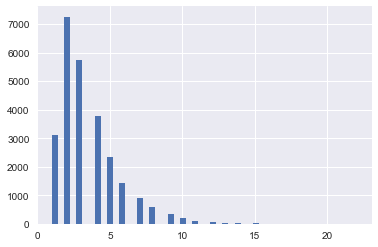

In [14]:
origin['max_depth'].hist(bins = 50)

In [15]:
origin.to_csv(base_path+'\\sample_origin.csv',
                sep='\001',
                index_label='w_id',
                encoding='utf-8',
                quoting=3)
repo.to_csv(base_path+'\\sample_repo.csv',
                sep='\001',
                index=False,
                encoding='utf-8',
                quoting=3,)